### Cartographer Background

A fundamental task in the analysis of time resolved crystallography data is the synthesis of fourier difference map from merged structure factor amplitudes. 
In principle, this is a simple task, whereby the difference map coefficients are given by $\Delta F_h = |F^{es}_h| - |F^{gs}_h|$. 
The corresponding phases can simply be taken to be the ground state phases computed from a suitable reference model. 
However, this approach is often too simplistic for routine analysis, and various strategies must be used to overcome errors in the estimates of $\Delta F$.
Common tactics include, weighting schemes, truncation, and local scaling.
These approaches can be made to work, but they are arbitrary and often require a grid search of parameters and manual inspection of resulting map coefficients in real space. 
The purpose of this notebook and accompanying statistical routines is to develop a more rigorous and robust procedure for estimating fourier difference map coefficients. 

It's our assertion, that many of the woes in constructing accurate difference maps can be attributed to incomplete excitation of the sample. 
The remainder of this notebook will attempt to
1. Characterize the impact of incomplete excitation on observed $\Delta F$
2. Evolve resonable priors on difference map coefficients
3. Describe a Bayesian routine for map coefficient inference 

### Incomplete Excitation Skews Observed Differences of Magnitudes
This notebook will discuss the behavior of the observed "Difference of Magnitudes ($DOM$)". 
$DOM = |F^{es}| - |F^{gs}|$. 
Often $DOM$ is taken to be the same as $\Delta F$. 
However, for the purposes of this discussion, we wish to be very explicit when we refer to the complex $\Delta F$ vs the scalar $DOM$. 
The term, $DOM$ will in general refer to the difference in magnitudes between the fully excited and fully ground state structure factor amplitudes. 
$DOM_{obs}$ will be used to refer to the fraction of the full $DOM$ which would be observed experimentally.

$DOM_{obs} = |F^{es}_{obs}| - |F^{gs}_{obs}|$

The random diffuse model governs the expected behavior of a time resolved crystallography experiment under the assumption that the excited molecules are distributed randomly throughout the lattice. 
The model stats that the experimentally observed excited state structure factors are a convex combination of the ground and true excited state structure factors.
That is,

$$
F^{es}_{obs} = p F^{es} + (1-p) F^{gs}, 
$$

where the excited fraction $p \in [0, 1]$.
In this situation, the observed difference of magnitude is given by
$$
DOM_{obs} =  |p F^{es}_{obs} + (1-p) F^{gs} | - |F^{gs}
$$

The following cells demonstrate that the effect of incomplete excitation is to shift the mean of the $DOM_{obs}$ distribution to the negative. 


In [36]:
%pylab inline

#These are example data for a simulated ground and excited state random atom model
#The coordinates of the excited state atoms have just been jittered with respect to ground
Foff = np.load('data/Foff.npy')
Fon  = np.load('data/Fon.npy')
D = np.load('data/dHKL.npy')


from ipywidgets import interactive

p = np.linspace(0, 1, 100)
Fon_obs = p[:,None] * Fon + (1. - p[:,None])*Foff
DOM_obs = np.abs(Fon_obs) - np.abs(Foff)[None,:]
a,bins = np.histogram(DOM_obs, 100)
ylim = a.max()

def plot(p):
    plt.figure(1)
    plt.title("$DOM_{obs}$")
    DOM_obs = np.abs(p*Fon + (1. - p)*Foff) - np.abs(Foff)
    plt.hist(DOM_obs, bins, color='k', density=True)
    plt.axvline(np.mean(DOM_obs), color='r', ls='--', label='mean')
    plt.axvline(np.median(DOM_obs), color='b', ls='--', label='median')
    plt.legend()
    plt.show()

interactive(plot, p=(0., 1., .01))

Populating the interactive namespace from numpy and matplotlib


interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

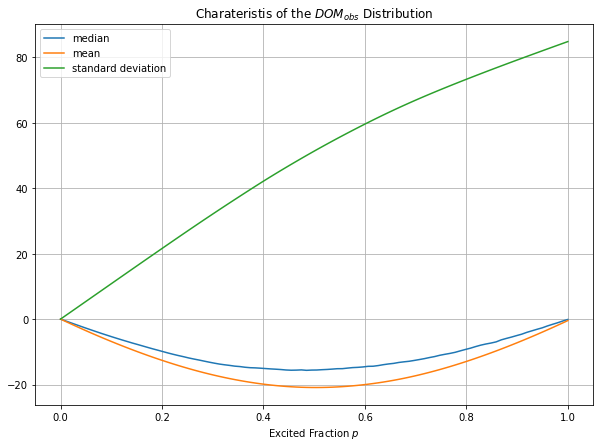

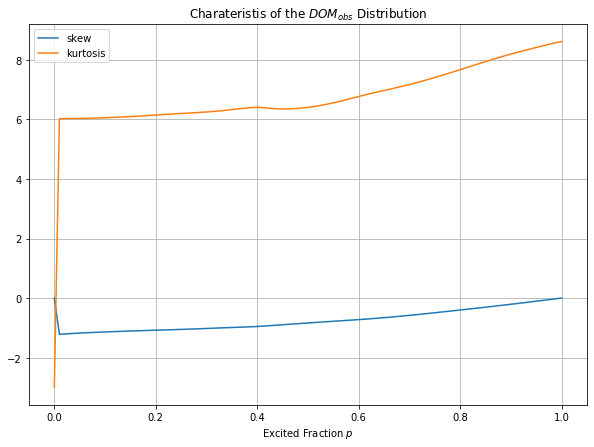

In [40]:
p = np.linspace(0, 1, 100)
Fon_obs = p[:,None] * Fon + (1. - p[:,None])*Foff
DOM_obs = np.abs(Fon_obs) - np.abs(Foff)[None,:]

plt.figure(figsize = (10, 7))
plt.plot(p, np.median(DOM_obs, 1), label='median')
plt.plot(p, np.mean(DOM_obs, 1), label='mean')
plt.plot(p, np.std(DOM_obs, 1), label='standard deviation')
plt.title("Charateristis of the $DOM_{obs}$ Distribution")
plt.xlabel("Excited Fraction $p$")
plt.grid()
plt.legend()

plt.figure(figsize = (10, 7))
from scipy.stats import skew, kurtosis
plt.plot(p, skew(DOM_obs, 1), label='skew')
plt.plot(p, kurtosis(DOM_obs, 1), label='kurtosis')
plt.title("Charateristis of the $DOM_{obs}$ Distribution")
plt.xlabel("Excited Fraction $p$")
plt.grid()
plt.legend()

Accordingly, the random diffuse model predicts that the observed $DOM_{obs}$ distribution should have a negative center and slightly negative skew. 
Furthermore, we assert that this skew should likely be present even in jointly scaled data. 
However, this skew diminishes in the case of complete excitation.
Perhaps it is possible to use the centeredness of the $DOM_{obs}$ distribution as a criterion for inference of properly scaled complex difference fourier coefficients.

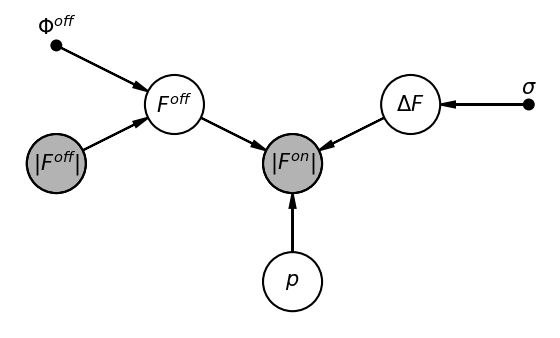

In [49]:
import daft

g = daft.PGM()
g.add_node("p", content='$p$', x=2, y=-1.0)
g.add_node("DeltaF", content='$\Delta F$', x=3, y=0.5)
g.add_node("sigma", content='$\sigma$', x=4, y=0.5, fixed=True)
g.add_node("Phioff", content='$\Phi^{off}$', x=0, y=1, fixed=True)
g.add_node("Foff", content='$F^{off}$', x=1, y=0.5)
g.add_node("abs Fon", content='$|F^{on}|$', x=2.0, y=0.0, observed=True)
g.add_node("abs Foff", content='$|F^{off}|$', x=0, y=0., observed=True)
g.add_edge("sigma", "DeltaF")
g.add_edge("DeltaF", "abs Fon")
g.add_edge("Foff", "abs Fon")
g.add_edge("p", "abs Fon")
g.add_edge("Phioff", "Foff")
g.add_edge("abs Foff", "Foff")
g.render(dpi = 150)

$$
\Delta F \sim MVN(0, \sigma I) \\
F^{off} \sim MVN(\mu_{F^{off}}, \sigma_{|F^{off}|}I) \\
p(|F^{on}|\ | \Delta F, p, F^{off} ) = N(|p\Delta F + Foff|\ |\ |F^{on}|, \sigma_{F^{on}} )\\
$$

$$
\mu_{F^{off}} = \{|F^{off}|\cos\Phi^{off},|F^{off}|\sin\Phi^{off}\}
$$